In [1]:
import sys
sys.path.remove('/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python')
sys.path.insert(1, "/Library/Python/2.7/site-packages/scipy")

from __future__ import division

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

from StringIO import StringIO

from scipy.stats import norm, multivariate_normal, beta, binom, stats, invgamma
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.special import gamma
from scipy.optimize import fmin
from scipy.interpolate import spline
from scipy.linalg import sqrtm
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

Simple graph in python

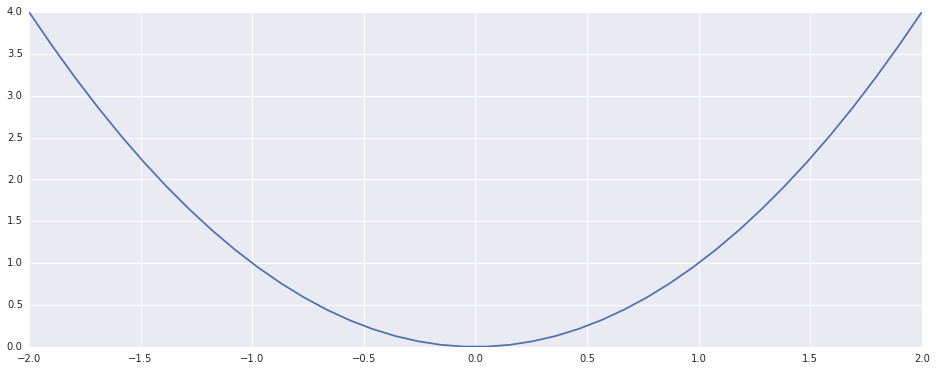

In [2]:
"""
02_SimpleGraph.py
A simple graph drawn by Python :-)
"""
x = np.linspace(-2, 2, 40)
y = x**2

plt.figure(figsize=(16,6))
plt.plot(x, y)
plt.show()

Integral of density

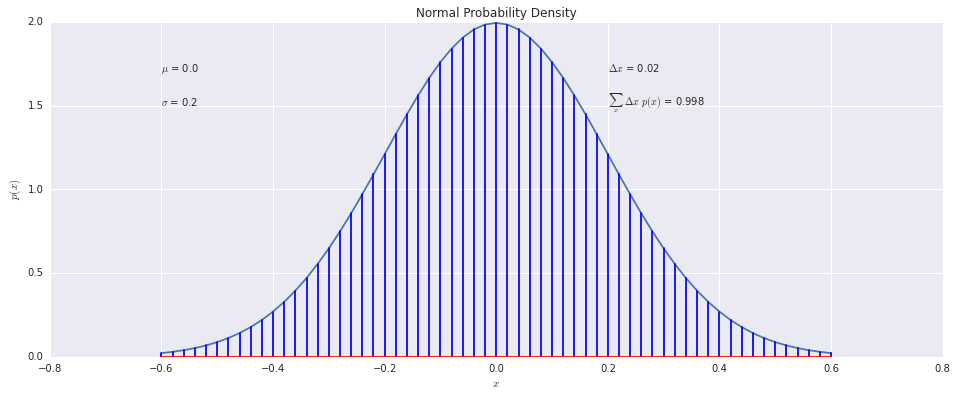

In [3]:
mean = 0.0
sd = 0.2
xlow = mean - 3.0 * sd
xhigh = mean + 3.0 * sd
dx = 0.02

x = np.arange(xlow, xhigh, dx)
gaussian_x = (1./np.sqrt(2 * np.pi * sd ** 2)) * np.exp(-0.5 * ((x - mean)/sd)**2)

plt.figure(figsize=(16, 6))
plt.plot(x, gaussian_x)
plt.stem(x, gaussian_x, markerfmt=' ')

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.title('Normal Probability Density')
# Approximate the integral as the sum of width * height for each interval.
area = np.sum(dx*gaussian_x)
# Display info in the graph.
_ = plt.text(-.6, 1.7, '$\mu$ = %s' % mean)
_ = plt.text(-.6, 1.5, '$\sigma$ = %s' % sd)
_ = plt.text(.2, 1.7, '$\Delta x$ = %s' % dx)
_ = plt.text(.2, 1.5, '$\sum_{x}$ $\Delta x$ $p(x)$ = %5.3f' % area)

Running proportion

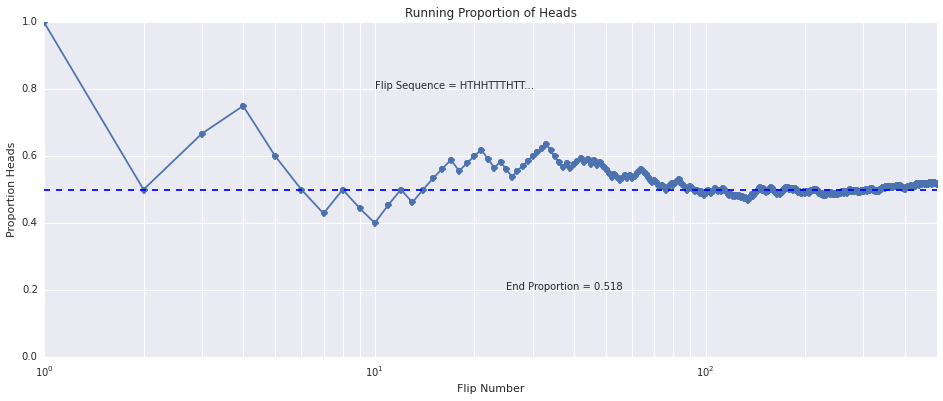

In [4]:
# Specify total number of flipping a coin
N = 500
# Generate random sample of tail and head
np.random.seed(10)
flip_sequence = np.random.choice([0, 1], p=(0.5, 0.5), size=N, replace=True)

r = np.cumsum(flip_sequence)
n = np.linspace(1, N, N)
run_prop = r / n

# Graph the running proportion:
plt.figure(figsize=(16,6)) # Brian added
plt.plot(n, run_prop, '-o', )
plt.xscale('log')  # an alternative to plot() and xscale() is semilogx()
plt.xlim(1, N)
plt.ylim(0, 1)
plt.xlabel('Flip Number')
plt.ylabel('Proportion Heads')
plt.title('Running Proportion of Heads')
# Plot a dotted horizontal line at y=.5, just as a reference line:
plt.axhline(y=.5, ls='dashed')

# Display the beginning of the flip sequence.
flipletters = ''.join(["T","H"][flip] for flip in flip_sequence[:10])

_ = plt.text(10, 0.8, 'Flip Sequence = %s...' % flipletters)
# Display the relative frequency at the end of the sequence.
_ = plt.text(25, 0.2, 'End Proportion = %s' % run_prop[-1])

Number of head in the sequence is: 259
Number of tail in the sequene is: 241


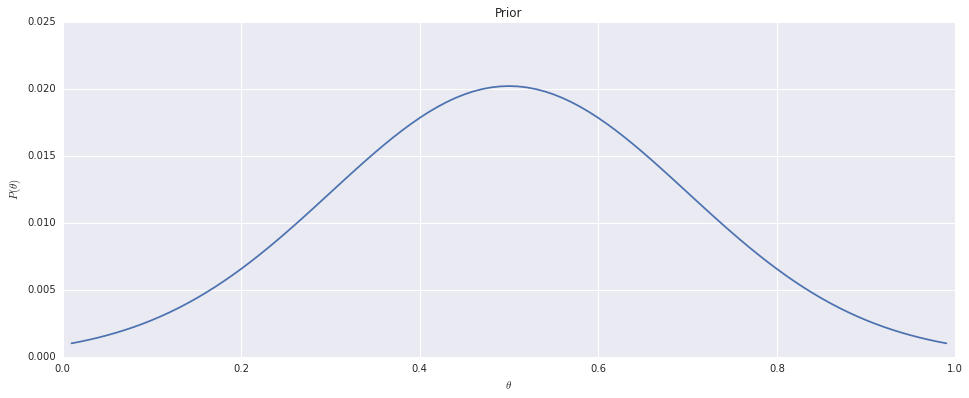

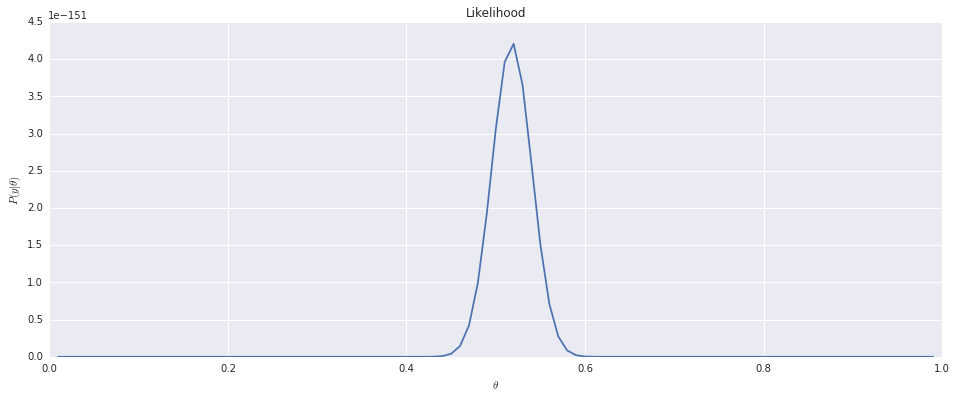

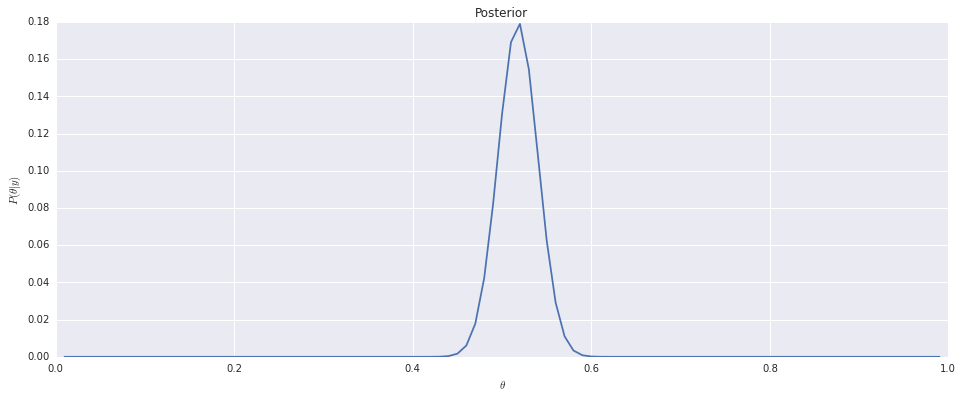

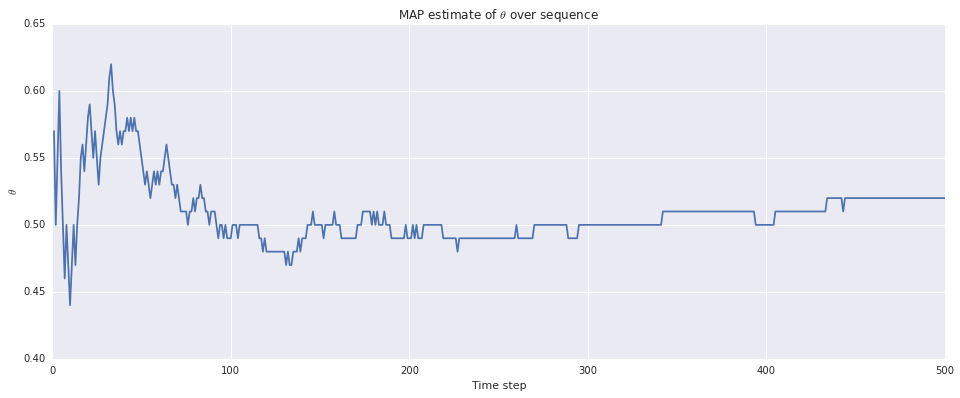

In [5]:
n_theta_vals = 99.

# Generate the a sequence of theta
theta = np.linspace(1. / (n_theta_vals+1.), n_theta_vals / (n_theta_vals + 1.), int(n_theta_vals))

# Assuming the prior probability follows a normal density function
p_theta = norm.pdf(theta, 0.5, 0.2)
p_theta = p_theta / np.sum(p_theta)

# Specify data
data = flip_sequence
head = np.sum(data)
tail = len(data) - head
print "Number of head in the sequence is:", head
print "Number of tail in the sequene is:", tail

# Calculate the Likelihood of all these priors
likelihood = theta ** head * (1 - theta) ** tail

# Calculate the posterior
posterior = likelihood * p_theta
posterior = posterior / np.sum(posterior)

# Check how posterior changes over the sequence
prior = p_theta
MAP_list = []
for obs in flip_sequence:
    temp_likelihood = theta if obs == 1 else (1.-theta)
    temp_posterior = temp_likelihood * prior
    prior = temp_posterior
    MAP_list.append(theta[np.argmax(prior)])
    
# Plot prior
plt.figure(figsize=(16,6))
plt.plot(theta, p_theta)
plt.title("Prior")
plt.xlabel("$\\theta$")
plt.ylabel("$P(\\theta)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(theta, likelihood)
plt.title("Likelihood")
plt.xlabel("$\\theta$")
plt.ylabel("$P(y|\\theta)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(theta, posterior)
plt.title("Posterior")
plt.xlabel("$\\theta$")
plt.ylabel("$P(\\theta|y)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(len(MAP_list)) + 1, MAP_list)
plt.title("MAP estimate of $\\theta$ over sequence")
plt.xlabel("Time step")
plt.ylabel("$\\theta$")
plt.show()

HID of ICDF
HDI of a probability density function

In [6]:
def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

Inferring a binomial proportion via exact mathematical analysis.<br>Following the example in the textbook, the problem is described as below:

* Say we have 500 new borners, the sex of thse babies are tagged as 1 (girl) and 0 (boy)
* The prior distribution of the probablity to have new baby girl follows a uniform distribution / binomial distribution
* We are going to estimate the posterior

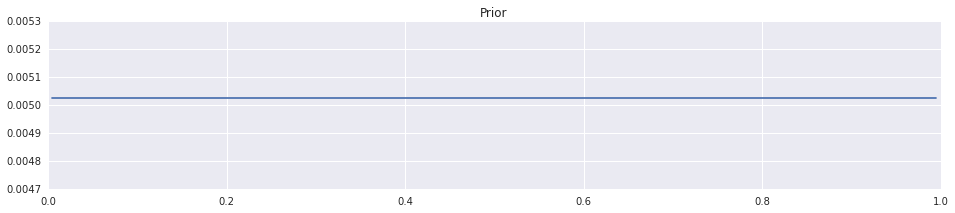

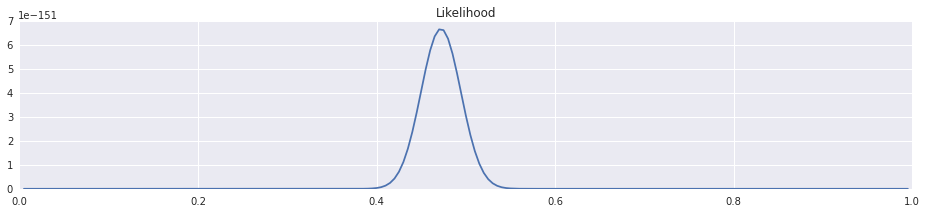

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


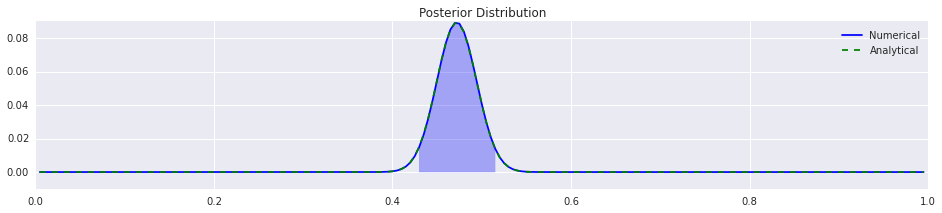

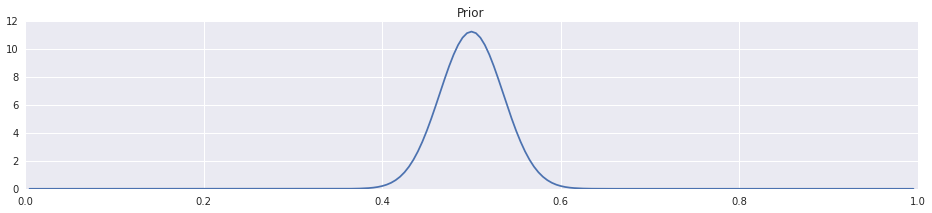

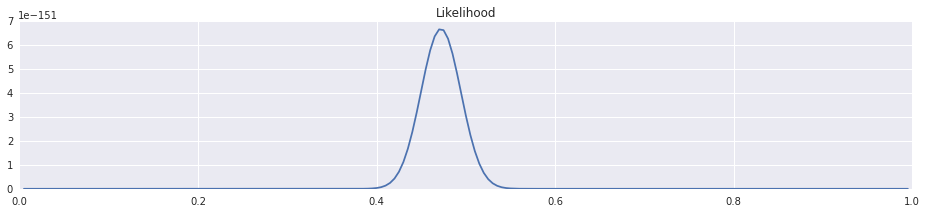

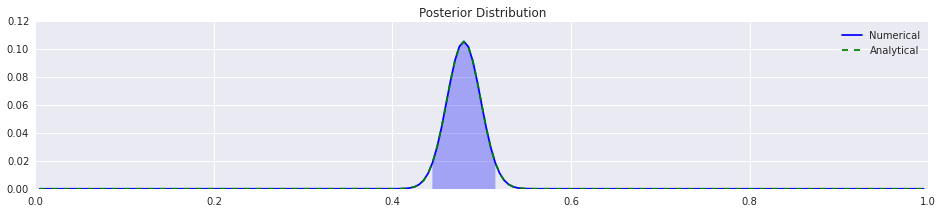

In [9]:
def binom_beta(theta, p_theta, data_vec, cred_mass=0.95, uniform = True):
    # theta and p_theta are priors has to be either uniform distribution or binomial distribution
    n_girls = np.sum(data_vec)
    n_boys = len(data_vec) - n_girls
    p_data_given_theta = theta ** n_girls * (1-theta) ** n_boys
    p_theta_given_data = p_data_given_theta * p_theta / np.sum(p_data_given_theta * p_theta)
    
    if uniform:
        post_a = n_girls
        post_b = n_boys
    else:
        def pdf_diff(t):
            a, b = t
            return np.sqrt(np.nanmean((p_theta - beta.pdf(theta, a, b))**2))
        prior_a, prior_b = fmin(pdf_diff, np.array([80, 120]), ftol=1e-8, disp=False)
        post_a = prior_a + n_girls
        post_b = prior_b + n_boys
        
    p_theta_given_data_analytical = beta.pdf(theta, post_a, post_b)
    p_theta_given_data_analytical = p_theta_given_data_analytical / np.sum(p_theta_given_data_analytical)
    intervals = HDIofICDF(beta, cred_mass, a=post_a, b=post_b)
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_theta)
    plt.title("Prior")
    plt.show()
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_data_given_theta)
    plt.title("Likelihood")
    plt.show()
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_theta_given_data, '-b')
    plt.plot(theta, p_theta_given_data_analytical, '--g')
    plt.legend(["Numerical", "Analytical"])
    plt.title("Posterior Distribution")
    plt.fill_between(theta, 0, p_theta_given_data, 
                     where=np.logical_and(theta > intervals[0], 
                                          theta < intervals[1]),
                     color='blue', alpha=0.3)
    plt.show()


# uniform prior
n_thetas = 199.
theta_uniform = np.linspace(1. / (n_thetas + 1.), n_thetas / (n_thetas + 1.), int(n_thetas))
p_theta_uniform = 1. / len(theta_uniform) * np.ones(len(theta_uniform))

# binomial prior
# n_thetas = 199.
theta_binom = np.linspace(1. / (n_thetas + 1.), n_thetas / (n_thetas + 1.), int(n_thetas))
p_theta_binom = beta.pdf(theta_binom, 100, 100)
data_vec = np.random.choice([0, 1], p=(0.545, 0.455), size=500, replace=True)

binom_beta(theta_uniform, p_theta_uniform, data_vec, uniform=True)
binom_beta(theta_binom, p_theta_binom, data_vec, uniform=False)

Beta Posterior Predictions<br>
Posterior predictive check. Examine the veracity of the winning model by simulating data sampled from the winning model and see if the simulated data 'look like' the actual data

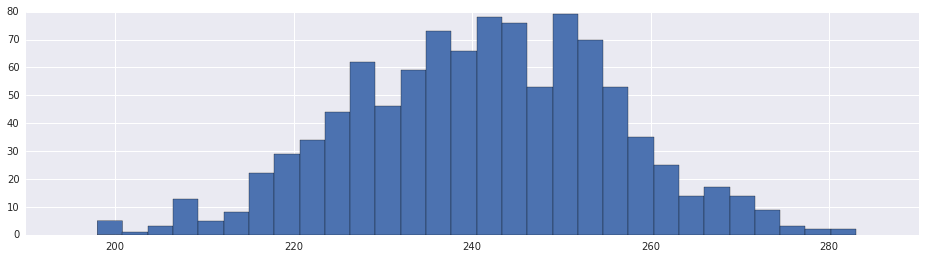

In [10]:
# Specify known values of prior and actual data
prior_a = 100
prior_b = 100
actual_data_Z = 237
actual_data_N = 500

# Compute posterior parameter values
post_a = prior_a + actual_data_Z
post_b = prior_b + actual_data_N - actual_data_Z

# Number of flips in a simulated sample should match the actual sample size
sim_sample_size = actual_data_N

# Designate an arbitrarily large number simulated samples
n_sim_samples = 1000
sim_sample_Z_record = np.zeros(n_sim_samples)
                              
for sample_idx in range(n_sim_samples):
    sample_theta = beta.rvs(post_a, post_b)
    sample_data = np.random.choice([0, 1], p=[1-sample_theta, sample_theta],
                                  size=sim_sample_size, replace=True)
    sim_sample_Z_record[sample_idx] = sum(sample_data)
    
plt.figure(figsize=(16, 4))
plt.hist(sim_sample_Z_record, bins=30)
plt.show()

Measure the speed of light by estimating parameter with nuisance parameter (Normal data with a noninformative prior distribution)

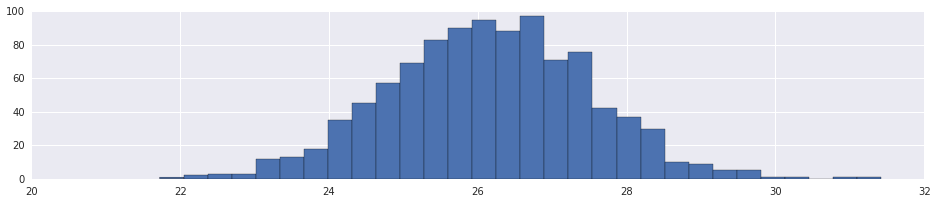

Mean is: 26.1496498171
Central interval: [23.4105190899, 28.7380849869]


In [11]:
mean = 26.2
s = 10.8
df = 65
N_simulations = 1000
sigma_2_draws = df * s**2 / np.random.chisquare(df, size=N_simulations)
mu_draws = np.zeros(N_simulations)
for i, sigma_2 in enumerate(sigma_2_draws):
    mu = np.random.normal(loc=mean, scale=np.sqrt(sigma_2 / 66.), size=1)
    mu_draws[i] = mu

plt.figure(figsize=(16, 3))
plt.hist(mu_draws, bins=30)
plt.show()

print "Mean is:", np.nanmean(mu_draws)
low_percentile = str(np.percentile(mu_draws, 2.5))
high_percentile = str(np.percentile(mu_draws, 97.5))
print "Central interval: [" + low_percentile + ", " + high_percentile + "]"

Presidential election, page 69 on Gelman's book

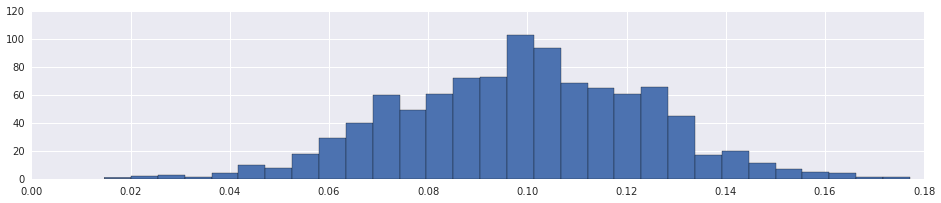

In [12]:
y_1 = 727
y_2 = 583
y_3 = 137

alpha_1 = 1
alpha_2 = 1
alpha_3 = 1

n_samples = 1000
samples = np.random.dirichlet((y_1+alpha_1, y_2+alpha_2, y_3+alpha_3), size=n_samples)

theta_1_2_diff = samples[:, 0] - samples[:, 1]
plt.figure(figsize=(16, 3))
plt.hist(theta_1_2_diff, bins=30)
plt.show()

Analysis of a bioassay experiment<br> page 75 of Gelman book

$$(x_i, n_i, y_i); \quad i = 1, \dots, k$$

where $x_i$ represents the $i$th of $k$ dose levels (often measured on a log scale) given to $n_i$ animals, of which $y_i$ subsequently respond with positive outcome. An example of real data from such an experiment is shown in Table 3.1: twenty animals were tested, five at each of four dose levels.

1. _Modeling the dose-response relation_
    * Assuming that the data points $y_i$ are binomially distributed:
    $$y_i|\theta_i\sim\textrm{Bin}(n_i, \theta_i)$$
    Please note that the binomial model will not be appropriate when the desease is contagious
    
    * Assume the _dose-response relation_ is logit model:
    $$\textrm{logit}(\theta_i)=\alpha + \beta x_i$$
    
2. In this example I tried two priors:
    1. An informative prior, which is the MLE estimate of the logistic regression
    2. A noninformative prior, which is uniform across the field

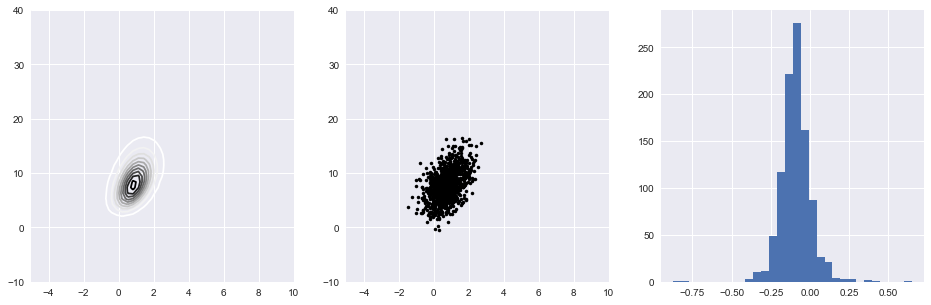

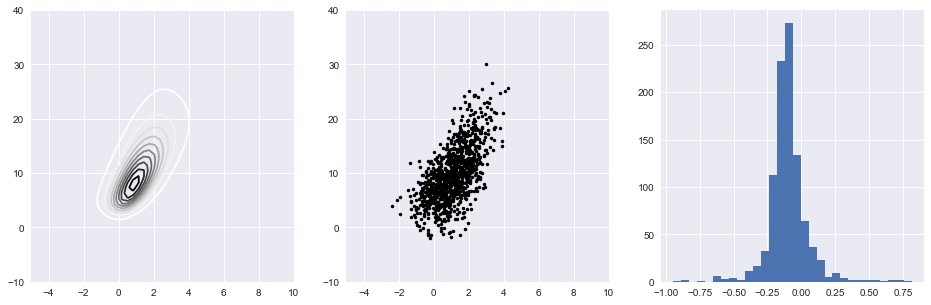

In [120]:
def bioassay():
    x = np.array([-0.86, -0.3, -0.05, 0.73])
    n = np.array([5, 5, 5, 5])
    y = np.array([0, 1, 3, 5])

    def negative_loglikelihood(params):
        alpha = params[0]
        beta = params[1]
        neg_loglikelihood = 0.
        for i in range(len(x)):
            neg_loglikelihood += (-y[i] * (alpha + beta * x[i]) + 
                                  (n[i]) * np.log(1. + np.exp(alpha + beta * x[i])))
        return neg_loglikelihood
    
    def logistic_standard_error(alpha, beta):
        loglikelihood_2nd_derivative = np.zeros((2, 2))
        for i in range(len(x)):
            multiplier = (- np.exp(alpha + beta * x[i]) / (np.exp(alpha + beta * x[i]) + 1) ** 2)
            loglikelihood_2nd_derivative[0, 0] += multiplier * n[i]
            loglikelihood_2nd_derivative[0, 1] += multiplier * x[i] * n[i]
            loglikelihood_2nd_derivative[1, 0] += multiplier * x[i] * n[i]
            loglikelihood_2nd_derivative[1, 1] += multiplier * (x[i] ** 2) * n[i]
        inv_neg_loglikelihood_2nd_derivative = np.linalg.inv(-loglikelihood_2nd_derivative)
        alpha_se = np.sqrt(inv_neg_loglikelihood_2nd_derivative[0, 0])
        beta_se = np.sqrt(inv_neg_loglikelihood_2nd_derivative[1, 1])
        return alpha_se, beta_se
    
    # MLE estimation on the logistic regression
    init_params = np.array([0.5, 0.5])
    opt_params = fmin(negative_loglikelihood, init_params, ftol=1e-8, disp=False)
    alpha_hat, beta_hat = opt_params
    alpha_hat_se, beta_hat_se = logistic_standard_error(alpha_hat, beta_hat)
    
    # Obtaining a contour plot of the joint posterior density
    alpha_range = np.linspace(-5, 10, 50)
    beta_range = np.linspace(-10, 40, 50)
    
    alpha_alpha, beta_beta = np.meshgrid(alpha_range, beta_range)
    
    alpha_norm = norm(loc=alpha_hat, scale=alpha_hat_se)
    beta_norm = norm(loc=beta_hat, scale=beta_hat_se)
    
    alpha_beta_p_space = np.column_stack((alpha_alpha.flatten(), beta_beta.flatten()))
    alpha_beta_p_space = np.column_stack((alpha_beta_p_space, np.zeros((len(alpha_beta_p_space), 2))))
    
    for i, row in enumerate(alpha_beta_p_space):
        temp_prior = alpha_norm.pdf(row[0]) * beta_norm.pdf(row[1])
        alpha_beta_p_space[i, 2] = temp_prior
        alpha_beta_p_space[i, 3] = (np.exp(-negative_loglikelihood(row)) * temp_prior)
    

    # Compute prior and joint posterior density
    prior_prior = alpha_beta_p_space[:, 2].reshape(alpha_alpha.shape)
    post_post = alpha_beta_p_space[:, 3].reshape(alpha_alpha.shape)
    max_post = np.max(post_post)
    levels = np.arange(0.05, 1.05, 0.1) * max_post
    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(131)
    plt.contour(alpha_alpha, beta_beta, post_post, levels=levels)
    
    # sampling from the joint posterior distribution
    n_samples = 1000
    marginal_alpha = np.sum(post_post, axis=0)
    marginal_alpha = marginal_alpha / np.sum(marginal_alpha)
    alpha_grid = alpha_alpha[0]
    
    def norm_alpha_pdf_diff(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(marginal_alpha) - norm.cdf(alpha_grid, a, b))**2))
    
    def norm_beta_pdf_diff(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(beta_given_alpha_sample) - norm.cdf(beta_grid, a, b))**2))
    
    alpha_mean, alpha_std = fmin(norm_alpha_pdf_diff, np.array([alpha_hat, alpha_hat_se]),
                                 ftol=1e-8, disp=False)
    samples = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        alpha_sample = norm.rvs(alpha_mean, alpha_std)
        alpha_col = np.argmin(np.abs(alpha_grid - alpha_sample))
        beta_grid = beta_beta[:, alpha_col]
        beta_given_alpha_sample = post_post[:, alpha_col].T
        beta_given_alpha_sample = beta_given_alpha_sample / np.sum(beta_given_alpha_sample)
        beta_mean, beta_std = fmin(norm_beta_pdf_diff, np.array([beta_hat, beta_hat_se]),
                                   ftol=1e-8, disp=False)
        beta_sample = norm.rvs(beta_mean, beta_std)
        samples[i] = [alpha_sample, beta_sample]
        
    fig.add_subplot(132)
    plt.plot(samples[:, 0], samples[:, 1], '.k')
    plt.xlim([-5, 10])
    plt.ylim([-10, 40])
    
    LD50 = -samples[:, 0] / samples[:, 1]
    LD50 = LD50[np.logical_and(LD50 <= 1.0, LD50 >= -1.0)]
    fig.add_subplot(133)
    plt.hist(LD50, bins=30)
    plt.show()
    
    # Compute prior and joint posterior based on uniform prior
    prior_prior_uniform = np.ones(alpha_alpha.shape) / (alpha_alpha.shape[0] * alpha_alpha.shape[1])
    prior_prior_uniform_flat = prior_prior_uniform.flatten()
    post_post_uniform_flat = np.zeros(alpha_alpha.shape).flatten()
    for i, row in enumerate(alpha_beta_p_space):
        post_post_uniform_flat[i] = (prior_prior_uniform_flat[i] * 
                                     np.exp(-negative_loglikelihood(row)))
    post_post_uniform = post_post_uniform_flat.reshape(alpha_alpha.shape)
    max_post_uniform = np.max(post_post_uniform)
    levels_uniform = np.arange(0.05, 1.05, 0.1) * max_post_uniform
    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(131)
    plt.contour(alpha_alpha, beta_beta, post_post_uniform, levels=levels_uniform)
    
    # sampling from the joint posterior distribution: prior is uniform
    marginal_alpha_uniform = np.sum(post_post_uniform, axis=0)
    marginal_alpha_uniform = marginal_alpha_uniform / np.sum(marginal_alpha_uniform)
    alpha_grid = alpha_alpha[0]
    
    def norm_alpha_pdf_diff_uniform(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(marginal_alpha_uniform) - norm.cdf(alpha_grid, a, b))**2))
    
    def norm_beta_pdf_diff_uniform(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(beta_given_alpha_sample_uniform) - norm.cdf(beta_grid, a, b))**2))
    
    alpha_mean_uniform, alpha_std_uniform = fmin(norm_alpha_pdf_diff_uniform, np.array([alpha_hat, alpha_hat_se]),
                                 ftol=1e-8, disp=False)
    samples_uniform = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        alpha_sample = norm.rvs(alpha_mean_uniform, alpha_std_uniform)
        alpha_col = np.argmin(np.abs(alpha_grid - alpha_sample))
        beta_grid = beta_beta[:, alpha_col]
        beta_given_alpha_sample_uniform = post_post_uniform[:, alpha_col].T
        beta_given_alpha_sample_uniform = beta_given_alpha_sample_uniform / np.sum(beta_given_alpha_sample_uniform)
        beta_mean_uniform, beta_std_uniform = fmin(norm_beta_pdf_diff_uniform, np.array([beta_hat, beta_hat_se]),
                                   ftol=1e-8, disp=False)
        beta_sample = norm.rvs(beta_mean_uniform, beta_std_uniform)
        samples_uniform[i] = [alpha_sample, beta_sample]
        
    fig.add_subplot(132)
    plt.plot(samples_uniform[:, 0], samples_uniform[:, 1], '.k')
    plt.xlim([-5, 10])
    plt.ylim([-10, 40])
    
    LD50 =  - samples_uniform[:, 0] / samples_uniform[:, 1]
    LD50 = LD50[np.logical_and(LD50 <= 1.0, LD50 >= -1.0)]
    fig.add_subplot(133)
    plt.hist(LD50, bins=30)
    plt.show()
                
bioassay()

Hierarchical modeling

In [13]:
def tumor_rats():
    alpha_prior = 1.4
    beta_prior = 8.6
    
    alpha_post = alpha_prior + 4
    beta_post = beta_prior + 10
    
    print beta.stats(alpha_post, beta_post)
    
tumor_rats()

(array(0.225), array(0.006975000000000001))


Tumor rats modeling, continued

* The observation $y_j$ are assumed to follow the Binomial distribution:
$$y_j\sim\textrm{Bin}(n_j, \theta_j)$$

* The parameter of observation, $\theta_j$ are assumed to be independent samples from a beta distribution:
$$\theta_j\sim\textrm{Beta}(\alpha, \beta)$$

* We are going to assign noninformative prior distribution for the prior of the hyperparameters to reflect our ignorance about the unknown of the hyperparameters.

prior is uniform over:
$$(\textrm{log}(\frac{\alpha}{\beta}), \textrm{log}(\alpha+\beta))$$

In [14]:
def load_tumor():
    y = []
    n = []
    with open("tumor.txt") as f:
        for line in f.readlines():
            split_line = line.split(" ")
            for it in split_line:
                split_it = it.split("/")
                y.append(int(split_it[0]))
                try:
                    n.append(int(split_it[1]))
                except Error as e:
                    n.append(int(split_it[1][:-2]))
    return np.array(y), np.array(n)

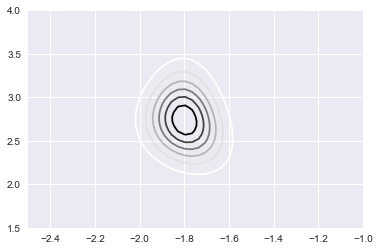

In [149]:
# please note the prior is on a transformed space of
y, n = load_tumor()

a = np.linspace(-2.5, -1, 50)
b = np.linspace(1.5, 4, 50)

aa, bb = np.meshgrid(a, b)

aa_transformed = np.exp(aa)
bb_transformed = np.exp(bb)

beta_beta = bb_transformed / (aa_transformed + 1)
alpha_alpha = aa_transformed * beta_beta

alpha_beta_prior = (alpha_alpha + beta_beta) ** (-2.5)
ab_prior = alpha_alpha * beta_beta * (alpha_alpha + beta_beta) ** (-2.5)

alpha_beta_post = np.ones(alpha_beta_prior.shape)
for y_j, n_j in zip(y, n):
    alpha_beta_post = (alpha_beta_post * gamma(alpha_alpha+beta_beta) / (gamma(alpha_alpha) * gamma(beta_beta)) *
                       gamma(alpha_alpha + y_j) * gamma(beta_beta + n_j - y_j) / gamma(alpha_alpha + beta_beta + n_j))
alpha_beta_post = alpha_beta_post * alpha_beta_prior

ab_post = alpha_beta_post * alpha_alpha * beta_beta
ab_post = ab_post / np.sum(ab_post)

plt.contour(aa, bb, ab_post)
plt.show()

#### Bayesian computations
In this part we implemented metropolis-hasting algorithm together with a gibbs sampler for the data in Chapter 11 Example.

In [15]:
def diet_loglikelihood(x):
    thetas = x[0:4]
    mu = x[4]
    log_sigma = x[5]
    log_tau = x[6]
    log_p = log_tau + np.sum(np.log(norm(loc=mu, scale=np.exp(log_tau)).pdf(thetas)))
    for i, diet in enumerate(diet_list):
        log_p += np.sum(np.log(norm(loc=thetas[i], scale=np.exp(log_sigma)).pdf(diet)))
    return log_p

def metropolis_hasting(x_0, target_fun, n_sims=500, log=True):
    x_i = np.copy(x_0)
    i = 0
    x_samples = np.zeros((n_sims, len(x_i)))
    x_samples[0] = x_i
    while i < n_sims - 1:
        x_i_next = multivariate_normal(mean=x_i, cov=np.diag(x_0 / 10.)).rvs(1)
        p_x_i_next = target_fun(x_i_next)
        p_x_i = target_fun(x_i)
        if log:
            if p_x_i_next - p_x_i >= 0:
                x_i = x_i_next
            else:
                rand = np.random.random()
                if rand <= np.exp(p_x_i_next - p_x_i):
                    x_i = x_i_next
        else:
            if p_x_i_next / p_x_i >= 1:
                x_i = x_i_next
            else:
                rand = np.random.random()
                if rand <= (p_x_i_next / p_x_i):
                    x_i = x_i_next
        i += 1
        x_samples[i] = x_i
    return x_samples

def gibbs_sampler(diet_data, n_sims = 1000):
    # initialize guess
    # theta_1,2,3,4, mu, sigma, tau
    params_sample = np.zeros((n_sims, 7))
    params = np.random.random(size=7)
    params_sample[0] = params
    i = 0
    while i < n_sims - 1:
        # sample theta
        for j, diet in enumerate(diet_data):
            mult_tau = 1. / params[-1]**2
            mult_sigma = float(len(diet)) / params[-2]**2
            mu = params[4]
            theta_j_hat = ((mult_tau * mu + mult_sigma * np.mean(diet))/
                           (mult_tau + mult_sigma))
            var_theta_j = (1. / (mult_tau + mult_sigma))
            params[j] = norm(loc=theta_j_hat, scale=np.sqrt(var_theta_j)).rvs(1)
        
        # sample mu
        mu_hat = 1. / float(len(diet_data)) * np.sum(params[:4])
        params[4] = norm(loc=mu_hat, 
                         scale=params[-1]**2/float(len(diet_data))).rvs(1)
        
        # sample sigma
        squared_sum = 0.
        for j, diet in enumerate(diet_data):
            squared_sum += np.sum((diet - params[j]) ** 2)
        sigma_hat_squared = 1. / float(len(np.concatenate(diet_data))) * squared_sum
        invgamma_loc = float(len(np.concatenate(diet_data))) / 2.
        invgamma_scale = np.sqrt(float(len(np.concatenate(diet_data))) * sigma_hat_squared/2.)
        params[5] = np.sqrt(invgamma(invgamma_loc, scale=invgamma_scale).rvs(1))
        
        # sample tau
        squared_tau_hat = 1. / 3. * np.sum((params[:4] - params[4])**2)
        params[6] = np.sqrt(invgamma(3./2.,
                                     scale=np.sqrt(3./2.* squared_tau_hat)).rvs(1))
        
        params_sample[i+1] = params
        i+=1
    return params_sample

In [16]:
# Init data
diet_list = [np.array([62, 60, 63, 59]),
             np.array([63, 67, 71, 64, 65, 66]),
             np.array([68, 66, 71, 67, 68, 68]),
             np.array([56, 62, 60, 61, 63, 64, 63, 59])]

############# Metropolis-Hasting ###############
# Init first guess of parameters
init_x = []
for diet in diet_list:
    init_x.append(np.mean(diet))
init_x.append(np.mean(np.concatenate(diet_list)))
init_x.append(np.log(np.std(np.concatenate(diet_list))))
init_x.append(np.log(np.std(np.concatenate(diet_list))))
init_x = np.array(init_x)

# Generate samples of parameters using metropolis-hasting
x_samples = metropolis_hasting(init_x, diet_loglikelihood)

# Print samples results
print x_samples[-1]
print np.median(x_samples, axis=0)[0:5]
print np.exp(np.median(x_samples, axis=0)[5:7])



############# Gibbs sampler ###############
params_sample_gibbs = gibbs_sampler(diet_list, n_sims=500)

print params_sample_gibbs[-1]
print np.median(params_sample_gibbs, axis=0)[0:5]
print np.exp(np.median(params_sample_gibbs, axis=0)[5:7])


[ 59.63722446  66.69476937  68.07185167  61.61395865  63.43774862
   0.86887767   1.40972496]
[ 59.92384831  66.69476937  68.07185167  61.61395865  63.43774862]
[ 2.43511511  4.31656881]
[ 61.07794376  66.07274009  68.47087343  60.74225495  62.03727292
   0.84929672   1.60238295]
[ 61.14276643  65.90549365  67.85586101  61.06681559  63.96447591]
[ 2.24210081  7.45580123]


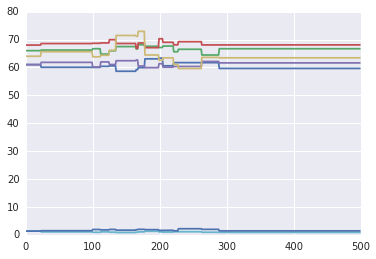

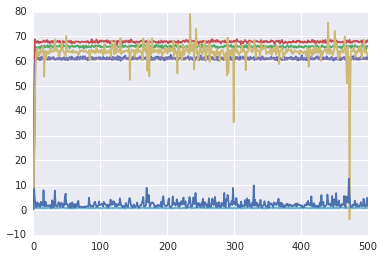

In [17]:
for j in range(x_samples.shape[1]):
    temp_params = x_samples[:, j]
    plt.plot(range(len(temp_params)), temp_params, '-')
plt.show()

for j in range(params_sample_gibbs.shape[1]):
    temp_params = params_sample_gibbs[:, j]
    plt.plot(range(len(temp_params)), temp_params, '-')
plt.show()

In [18]:
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = np.mean(param_sample_vec)
    post_summary['median'] = np.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*np.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * np.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(np.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary

In [40]:
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
with pm.Model() as model:
    theta = pm.Beta('theta', 1, 1)
    y = pm.Bernoulli('y', p=theta, observed=y)
    trace = pm.sample(500, pm.Metropolis(),
                      progressbar=True)

100%|██████████| 500/500 [00:01<00:00, 288.36it/s]

<MultiTrace: 1 chains, 500 iterations, 2 variables>


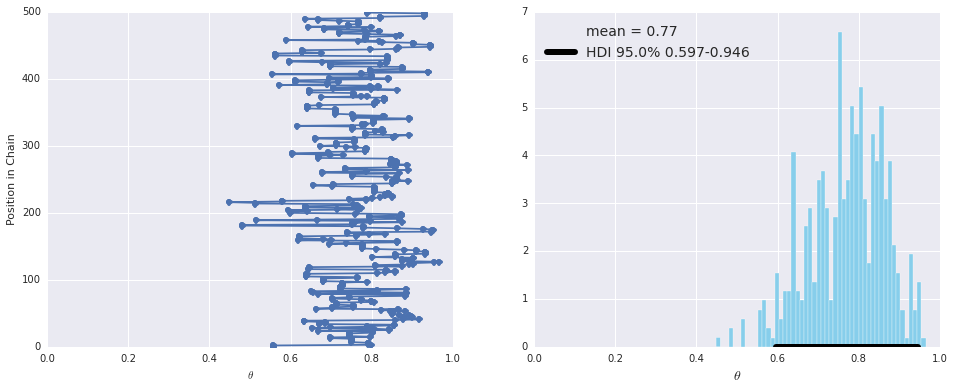

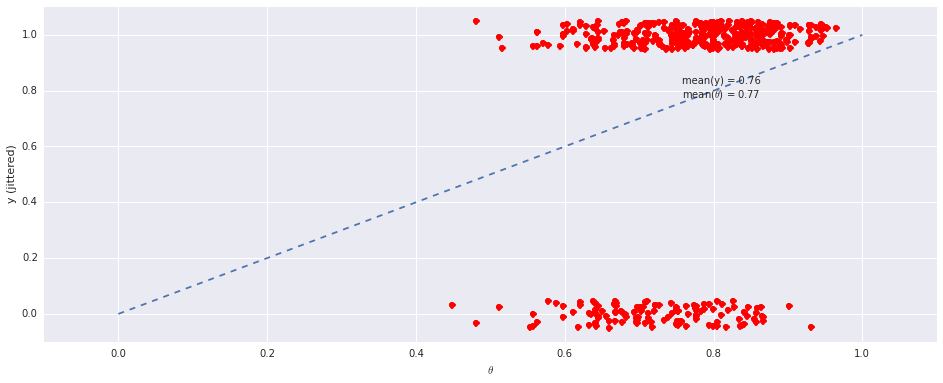

In [47]:
theta_sample = trace['theta']

plt.figure(figsize=(16,6)) # Brian added

plt.subplot(1, 2, 1)
plt.plot(theta_sample[:500], np.arange(500), marker='o')
plt.xlim(0, 1)
plt.xlabel(r'$\theta$')
plt.ylabel('Position in Chain')

plt.subplot(1, 2, 2)
mcmc_info = plot_post(theta_sample, xlab=r'$\theta$', show_mode=False)

# Posterior prediction:
# For each step in the chain, use posterior theta to flip a coin:
y_pred = np.zeros(len(theta_sample))
for i, p_head in enumerate(theta_sample):
    y_pred[i] = np.random.choice([0, 1], p=[1 - p_head, p_head])

# Jitter the 0,1 y values for plotting purposes:
y_pred_jittered = y_pred + np.random.uniform(-.05, .05, size=len(theta_sample))

# Now plot the jittered values:
plt.figure(figsize=(16,6)) # Brian added

plt.plot(theta_sample[:500], y_pred_jittered[:500], 'ro')
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)
plt.xlabel(r'$\theta$')
plt.ylabel('y (jittered)')

mean_y = np.mean(y_pred)
mean_theta = np.mean(theta_sample)

plt.plot(mean_y, mean_theta, 'k+', markersize=15)
plt.annotate('mean(y) = %.2f\nmean($\\theta$) = %.2f' %
    (mean_y, mean_theta), xy=(mean_y, mean_theta))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

In [20]:
"""
HDI_of_grid.py
Arguments:
probMassVec is a vector of probability masses at each grid point.
credMass is the desired mass of the HDI region.
Return a dictionary with:
indices is a vector of indices that are in the HDI
mass is the total mass of the included indices
height is the smallest component probability mass in the HDI
"""

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)
    return {'indices':idx, 'mass':HDImass, 'height':HDIheight}

Optimization terminated successfully.
         Current function value: 10.520845
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
P(Y1==1 and Y2==0) 0.371


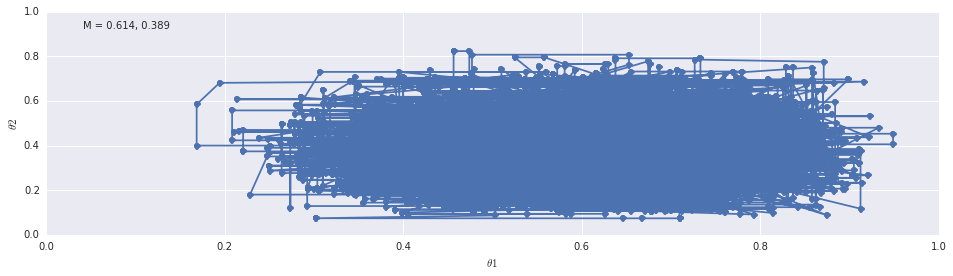

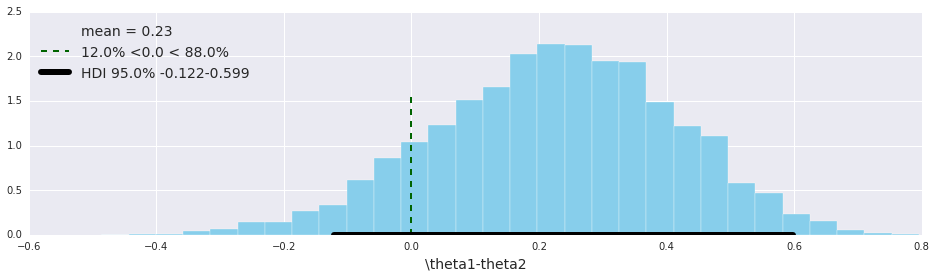

In [50]:
"""
08_BernTwoPyMC.py
Inferring two binomial proportions using PyMC.
"""

# Generate the data
y1 = np.array([1, 1, 1, 1, 1, 0, 0])  # 5 heads and 2 tails
y2 = np.array([1, 1, 0, 0, 0, 0, 0])  # 2 heads and 5 tails


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 3, 3)  # prior
    theta2 = pm.Beta('theta2', 3, 3)  # prior
    # define the likelihood
    y1 = pm.Bernoulli('y1', p=theta1, observed=y1)
    y2 = pm.Bernoulli('y2', p=theta2, observed=y2)

    # Generate a MCMC chain
    start = pm.find_MAP()  # Find starting value by optimization
    trace = pm.sample(10000, pm.Metropolis(),
                      progressbar=False)  # Use Metropolis sampling
    #start = pm.find_MAP()  # Find starting value by optimization
    #step = pm.NUTS()  # Instantiate NUTS sampler
    #trace = pm.sample(10000, step, start=start, progressbar=False)

# create an array with the posterior sample
theta1_sample = trace['theta1']
theta2_sample = trace['theta2']

# Plot the trajectory of the last 500 sampled values.
plt.figure(figsize=(16,4))
plt.plot(theta1_sample[:-500], theta2_sample[:-500], marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta2$')

# Display means in plot.
plt.plot(0, label='M = %.3f, %.3f' % (np.mean(theta1_sample), np.mean(theta2_sample)), alpha=0.0)

plt.legend(loc='upper left')

# Plot a histogram of the posterior differences of theta values.
plt.figure(figsize=(16,4))
theta_diff = theta1_sample - theta2_sample
plot_post(theta_diff, xlab=r'\theta1-theta2', comp_val=0.0, show_mode=False, bins=30)


# For Exercise 8.5:
# Posterior prediction. For each step in the chain, use the posterior thetas 
# to flip the coins.
chain_len = len(theta1_sample)
# Create matrix to hold results of simulated flips:
y_pred = np.zeros((2, chain_len))
for step_idx in range(chain_len):  # step through the chain
    # flip the first coin:
    p_head1 = theta1_sample[step_idx]
    y_pred[0, step_idx] = np.random.choice([0,1], p=[1-p_head1, p_head1])
    # flip the second coin:
    p_head2 = theta2_sample[step_idx]
    y_pred[1, step_idx] = np.random.choice([0,1], p=[1-p_head2, p_head2])


# Now determine the proportion of times that y1==1 and y2==0
pY1eq1andY2eq0 = sum((y_pred[0] ==1) & (y_pred[1] == 0)) / chain_len

print "P(Y1==1 and Y2==0)", pY1eq1andY2eq0
plt.show()

Simple linear regression using PyMC3

In [21]:
"""
HtWtDataGenerator.py
Random height, weight generator for males and females. Uses parameters from
Brainard, J. & Burmaster, D. E. (1992). Bivariate distributions for height and
weight of men and women in the United States. Risk Analysis, 12(2), 267-275.
John K. Kruschke, January 2008.
"""

def HtWtDataGenerator(nSubj, rndsd=None):
    # Specify parameters of multivariate normal (MVN) distributions.
    # Men:
    HtMmu = 69.18
    HtMsd = 2.87
    lnWtMmu = 5.14
    lnWtMsd = 0.17
    Mrho = 0.42
    Mmean = np.array([HtMmu , lnWtMmu])
    Msigma = np.array([[HtMsd**2, Mrho * HtMsd * lnWtMsd],
                     [Mrho * HtMsd * lnWtMsd, lnWtMsd**2]])

    # Women cluster 1:
    HtFmu1 = 63.11
    HtFsd1 = 2.76
    lnWtFmu1 = 5.06
    lnWtFsd1 = 0.24
    Frho1 = 0.41
    prop1 = 0.46
    Fmean1 = np.array([HtFmu1, lnWtFmu1])
    Fsigma1 = np.array([[HtFsd1**2, Frho1 * HtFsd1 * lnWtFsd1],
                     [Frho1 * HtFsd1 * lnWtFsd1, lnWtFsd1**2]])
    # Women cluster 2:
    HtFmu2 = 64.36
    HtFsd2 = 2.49
    lnWtFmu2 = 4.86
    lnWtFsd2 = 0.14
    Frho2 = 0.44
    prop2 = 1 - prop1
    Fmean2 = np.array([HtFmu2, lnWtFmu2])
    Fsigma2 = np.array([[HtFsd2**2 , Frho2 * HtFsd2 * lnWtFsd2],
                [Frho2 * HtFsd2 * lnWtFsd2 , lnWtFsd2**2]])

    # Randomly generate data values from those MVN distributions.
    if rndsd is not None:
        np.random.seed(rndsd)
    datamatrix = np.zeros((nSubj, 3))
    # arbitrary coding values
    maleval = 1
    femaleval = 0 
    for i in range(0, nSubj):
        # Flip coin to decide sex
        sex = np.random.choice([maleval, femaleval], replace=True, p=(.5,.5), size=1)
        if sex == maleval:
            datum = multivariate_normal.rvs(mean=Mmean, cov=Msigma) 
        if sex == femaleval:
            Fclust = np.random.choice([1, 2], replace=True, p=(prop1, prop2), size=1)
            if Fclust == 1:
                datum = multivariate_normal.rvs(mean=Fmean1, cov=Fsigma1)
            if Fclust == 2: 
                datum = multivariate_normal.rvs(mean=Fmean2, cov=Fsigma2)
        datamatrix[i] = np.concatenate([sex, np.round([datum[0], np.exp(datum[1])], 1)])

    return datamatrix

[ 69.7  67.5  68.5  67.3  60.9  66.4  60.4  68.   61.5  68.1  74.2  66.1
  66.   62.7  66.7  68.8  66.4  66.8  73.7  64.9  68.   58.6  64.6  62.4
  70.   60.7  72.4  63.6  62.   63.4]
[ 158.7  134.8  158.2  198.1  112.8  159.   104.1  155.4  189.2  143.5
  136.2  144.8  118.1  154.5  142.3  195.9  139.2  137.1  221.4  120.2
  198.9  107.2  139.8  176.6  180.1  144.9  173.2  161.3  148.6  131.9]
Optimization terminated successfully.
         Current function value: 75.012726
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10


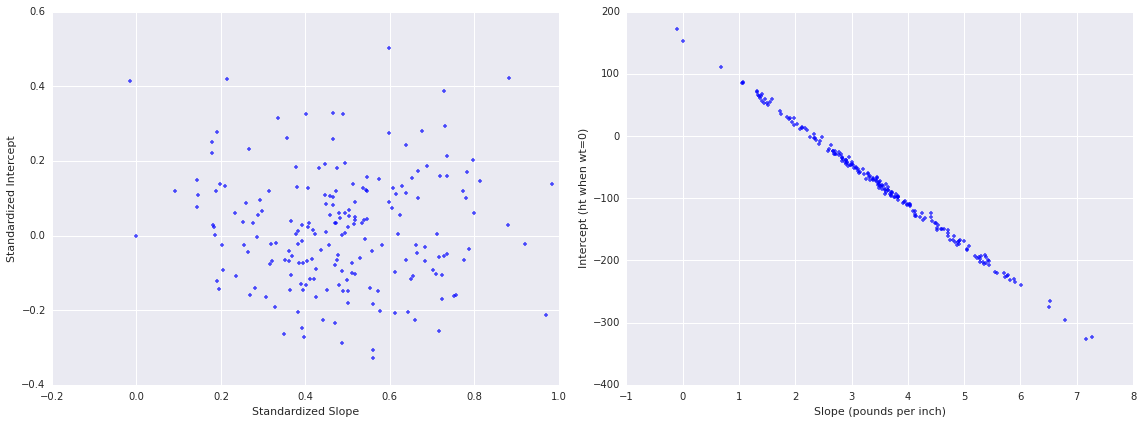

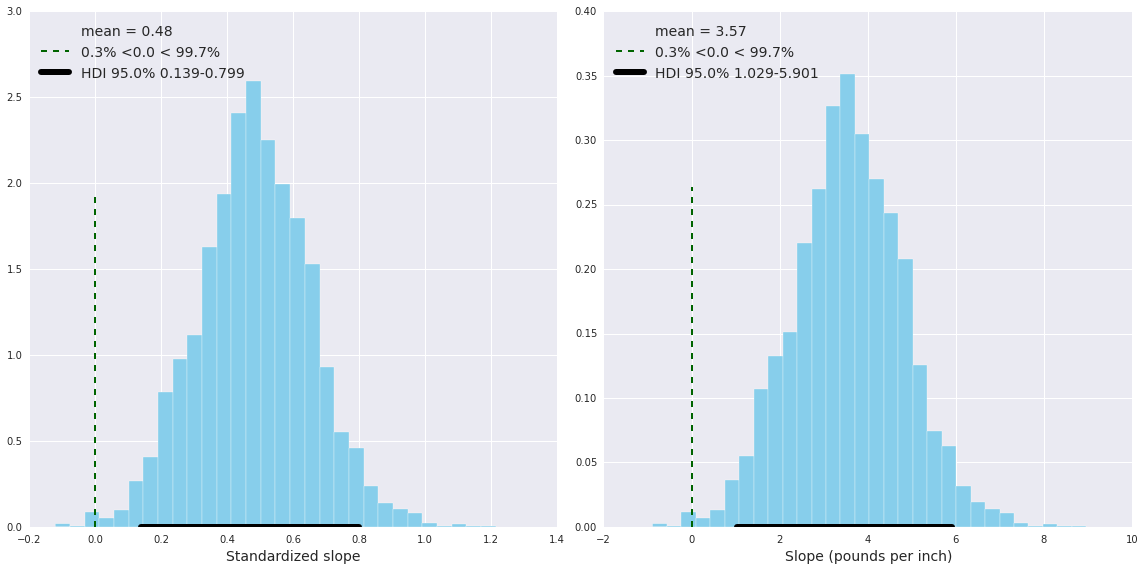

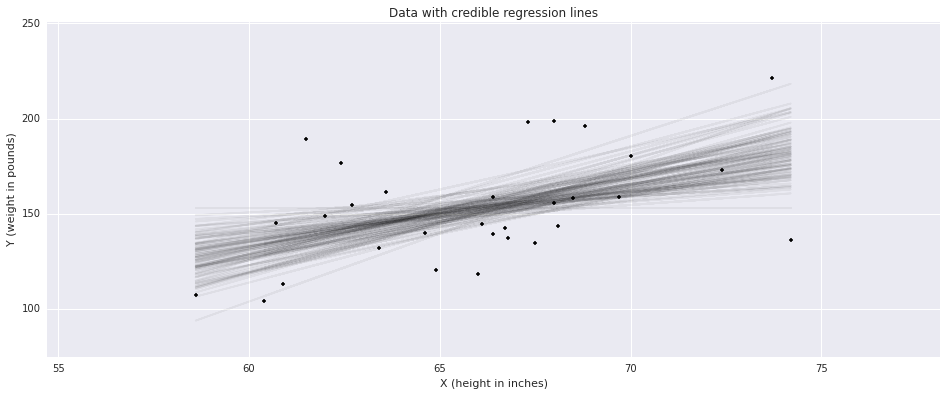

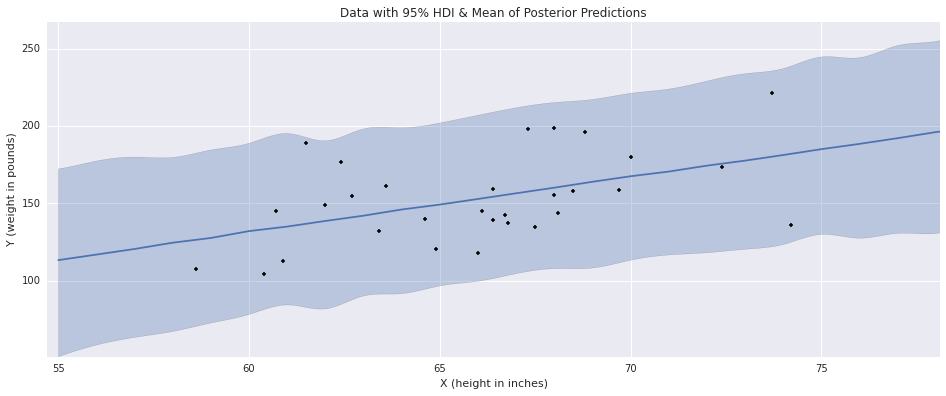

In [56]:
"""
16_SimpleLinearRegressionPyMC.py
Estimating the mean and standard deviation of a Gaussian likelihood with a
hierarchical model.
"""

# THE DATA.
# Simulated height and weight data:
n_subj = 30
HtWtData = HtWtDataGenerator(n_subj, rndsd=5678)
x = HtWtData[:,1]
y = HtWtData[:,2]

print x
print y

# Re-center data at mean, to reduce autocorrelation in MCMC sampling.
# Standardize (divide by SD) to make initialization easier.
x_m = np.mean(x)
x_sd = np.std(x)
y_m = np.mean(y)
y_sd = np.std(y)
zx = (x - x_m) / x_sd
zy = (y - y_m) / y_sd

# THE MODEL
with pm.Model() as model:
    # define the priors
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.Normal('beta1', mu=0, tau=1.0E-12)
    mu = beta0 + beta1 * zx
    # define the likelihood
    yl = pm.Normal('yl', mu=mu, tau=tau, observed=zy)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 5000
thin = 10

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[tau])
#pm.autocorrplot(trace, vars =[tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

## Extract chain values:
z0 = trace['beta0']
z1 = trace['beta1']
z_tau = trace['tau']
z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD


# Convert to original scale:
b1 = z1 * y_sd / x_sd
b0 = (z0 * y_sd + y_m - z1 * y_sd * x_m / x_sd)
sigma = z_sigma * y_sd


# Posterior prediction:
# Specify x values for which predicted y's are needed:
x_post_pred = np.arange(55, 81)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = norm.rvs(loc=b0[chain_idx] + b1[chain_idx] * x_post_pred ,
                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

## Display believable beta0 and b1 values
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
thin_idx = 50
plt.plot(z1[::thin_idx], z0[::thin_idx], 'b.', alpha=0.7)
plt.ylabel('Standardized Intercept')
plt.xlabel('Standardized Slope')
plt.subplot(1, 2, 2)
plt.plot(b1[::thin_idx], b0[::thin_idx], 'b.', alpha=0.7)
plt.ylabel('Intercept (ht when wt=0)')
plt.xlabel('Slope (pounds per inch)')
plt.tight_layout()

# Display the posterior of the b1:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_post(z1, xlab='Standardized slope', 
          comp_val=0.0, bins=30, show_mode=False)
plt.subplot(1, 2, 2)
plot_post(b1, xlab='Slope (pounds per inch)', 
          comp_val=0.0, bins=30, show_mode=False)
plt.tight_layout()

# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
# Plot data values:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x)-lim_mult*x_rang, np.max(x)+lim_mult*x_rang]
y_lim = [np.min(y)-lim_mult*y_rang, np.max(y)+lim_mult*y_rang]
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('X (height in inches)')
plt.ylabel('Y (weight in pounds)')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 100):
    plt.plot(x, b0[i] + b1[i]*x  , c='k', alpha=0.05 )

# Display data with HDIs of posterior predictions.

plt.figure(figsize=(16,6))
# Plot data values:
y_lim = [np.min(y_HDI_lim), np.max(y_HDI_lim)]
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('X (height in inches)')
plt.ylabel('Y (weight in pounds)')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_ave = np.average(y_post_pred, axis=1)
#Book version of the HDI representation
#plt.errorbar(x_post_pred,y_post_pred_ave, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_ave),
#                   abs(y_HDI_lim[:,1]-y_post_pred_ave)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_ave)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)


plt.show()

In [22]:
McIntyre1994 = """Brand,Tar,Nic,Wt,CO
Alpine,14.1,0.86,0.9853,13.6
BensonAndHedges,16.0,1.06,1.0938,16.6
BullDurham,29.8,2.03,1.1650,23.5
CamelLights,8.0,0.67,0.9280,10.2
Carlton,4.1,0.40,0.9462,5.4
Chesterfield,15.0,1.04,0.8885,15.0
GoldenLights,8.8,0.76,1.0267,9.0
Kent,12.4,0.95,0.9225,12.3
Kool,16.6,1.12,0.9372,16.3
LandM,14.9,1.02,0.8858,15.4
LarkLights,13.7,1.01,0.9643,13.0
Marlboro,15.1,0.90,0.9316,14.4
Merit,7.8,0.57,0.9705,10.0
MultiFilter,11.4,0.78,1.1240,10.2
NewportLights,9.0,0.74,0.8517,9.5
Now,1.0,0.13,0.7851,1.5
OldGold,17.0,1.26,0.9186,18.5
PallMallLight,12.8,1.08,1.0395,12.6
Raleigh,15.8,0.96,0.9573,17.5
SalemUltra,4.5,0.42,0.9106,4.9
Tareyton,14.5,1.01,1.0070,15.9
True,7.3,0.61,0.9806,8.5
ViceroyRichLight,8.6,0.69,0.9693,10.6
VirginiaSlims,15.2,1.02,0.9496,13.9
WinstonLights,12.0,0.82,1.1184,14.9
"""

Optimization terminated successfully.
         Current function value: 72.173142
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


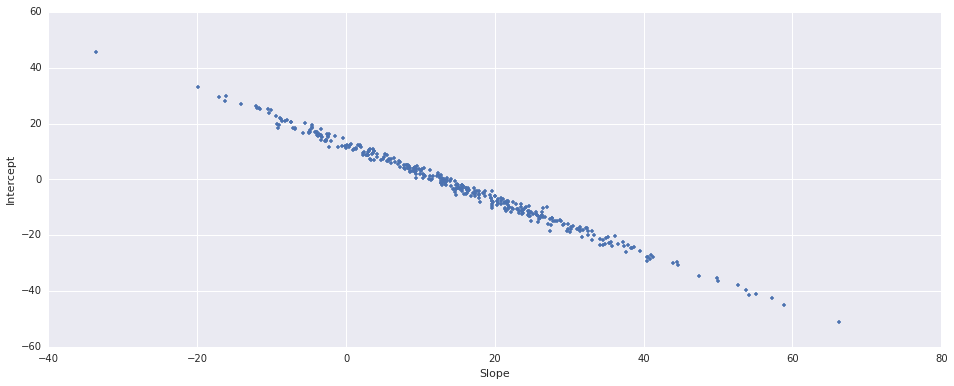

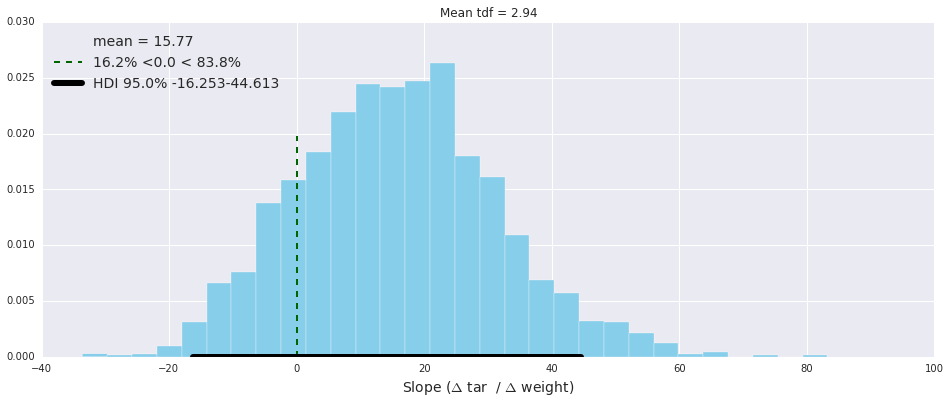

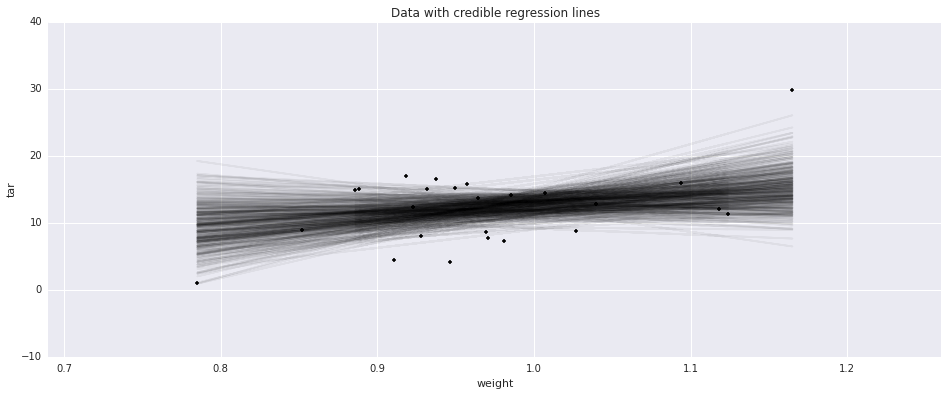

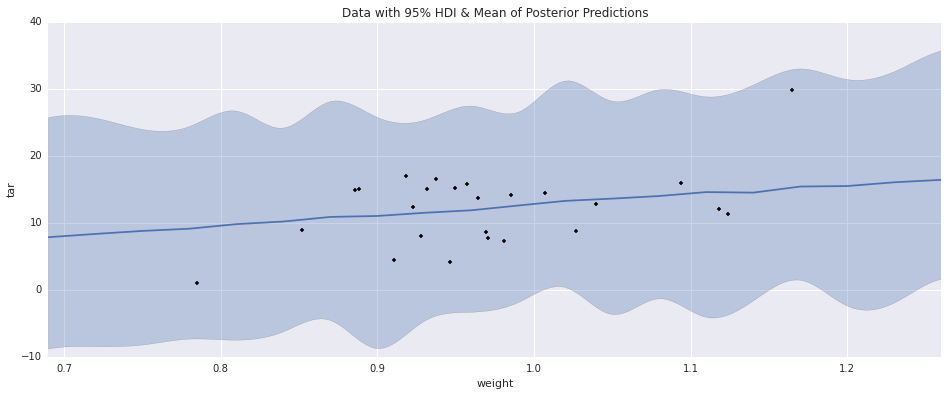

In [25]:
"""
16_SimpleRobustLinearRegressionPyMC.py
Simple Robust Linear Regression
"""
# THE DATA.

#cig_data = np.genfromtxt("McIntyre1994data.csv", skip_header=True, delimiter=",")
cig_data = np.genfromtxt(StringIO(McIntyre1994), skip_header=True, delimiter=",")

n_subj = len(cig_data)
x = cig_data[:,3]
y = cig_data[:,1]


# Re-center data at mean, to reduce autocorrelation in MCMC sampling.
# Standardize (divide by SD) to make initialization easier.
x_m = np.mean(x)
x_sd = np.std(x)
y_m = np.mean(y)
y_sd = np.std(y)
zx = (x - x_m) / x_sd
zy = (y - y_m) / y_sd

tdf_gain = 1 # 1 for low-baised tdf, 100 for high-biased tdf

tdf_gain = 1 # 1 for low-baised tdf, 100 for high-biased tdf

# THE MODEL
with pm.Model() as model:
    # define the priors
    udf = pm.Uniform('udf', 0, 1)
    tdf = 1 - tdf_gain * pm.math.log(1 - udf) # tdf in [1,Inf).
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.Normal('beta1', mu=0, tau=1.0E-12)
    mu = beta0 + beta1 * zx
    # define the likelihood
    yl = pm.StudentT('yl', mu=mu, lam=tau, nu=tdf, observed=zy)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 1000
thin = 10

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[tau])
#pm.autocorrplot(trace, vars =[tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


# Extract chain values:

tdf_samp = 1 - tdf_gain * np.log(1 - trace['udf'][burnin::thin])
tdf_m = np.mean(tdf_samp)
z0 = trace["beta0"][burnin::thin]
z1 = trace["beta1"][burnin::thin]
z_tau = trace["tau"][burnin::thin]
z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD

# Convert to original scale:
b1 = z1 * y_sd / x_sd
b0 = (z0 * y_sd + y_m - z1 * y_sd * x_m / x_sd)
sigma = z_sigma * y_sd

# Posterior prediction:
# Specify x values for which predicted y's are needed:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x) - lim_mult * x_rang, np.max(x) + lim_mult * x_rang]
#y_lim = [np.min(y) - lim_mult*y_rang, np.max(y) + lim_mult*y_rang]
y_lim = [-10, 40]
x_post_pred = np.linspace(x_lim[0], x_lim[1], 20)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = stats_t.rvs(df=np.repeat([tdf_samp[chain_idx]], [len(x_post_pred)]),
                            loc = b0[chain_idx] + b1[chain_idx] * x_post_pred,
                            scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])


# Display believable beta0 and b1 values
plt.figure(figsize=(16,6))
thin_idx = 5
plt.plot(b1[::thin_idx], b0[::thin_idx], '.')
plt.ylabel("Intercept")
plt.xlabel("Slope")

# Display the posterior of the b1:
plt.figure(figsize=(16,6))
plot_post(b1, xlab=r'Slope ($\Delta$ tar  / $\Delta$ weight)', comp_val=0.0,
            show_mode=False, bins=30)
plt.title('Mean tdf = %.2f' % tdf_m)

# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('weight')
plt.ylabel('tar')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 5):
    plt.plot(x, b0[i] + b1[i]*x  , c='k', alpha=0.05 )


plt.figure(figsize=(16,6))
# Plot data values:
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('weight')
plt.ylabel('tar')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_med = np.median(y_post_pred, axis=1)

#Book version of the HDI representation
#plt.errorbar(x_post_pred, y_post_pred_med, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_med),
#                   abs(y_HDI_lim[:,1]-y_post_pred_med)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_med)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)

plt.show()